In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score

# 1.데이터 로드


In [2]:
df_org = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Data/Machine_Signal_Labeled_50.csv')

In [3]:
# df_org 복사 => df
df = df_org.copy()

In [4]:
# df.head(3)
print('기지국 기기 개수 : {}개'.format(df.machine_id.nunique()))

기지국 기기 개수 : 51개


In [5]:
# 수치형 변수 목록
target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

In [6]:
# df[df[target_columns] < 0].isna().sum()

# 2.누락 데이터 보간

In [7]:
# 전체 데이터 shape
df.shape

(61633, 16)

In [8]:
# 시간 변수 생성
df['time'] = pd.to_datetime(df['date'].astype(str) + df['hour'].astype(str), format='%Y%m%d%H')

In [9]:
df.head(2)

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
0,MA1074_4_20210901_0,MA1074_4,20210901,0,17.598889,32.0,99.763033,100.000000,100.000000,30.361451,35.072902,101.157849,7.873696,11.028859,27753.51401,0,2021-09-01 00:00:00
1,MA1074_4_20210901_1,MA1074_4,20210901,1,13.039444,25.0,99.661017,99.516908,99.367089,22.009545,30.845568,101.483722,6.947635,10.664447,19952.83154,0,2021-09-01 01:00:00


## 2.1 시간 기준 키값 생성
- 누락된 시간대를 생성하기 위해, 원본 데이터와 join할 수 있는 고유키 역할의 기준 컬럼(기지국, 시간) 생성

In [10]:
start_date = df['time'].min() # 시작날짜
end_date = df['time'].max() # 끝날짜
print('시작 날짜 : {}'.format(start_date))
print('종료 날짜 : {}'.format(end_date))
time_index = pd.date_range(start_date, end_date, freq='H')
print('전체 시간 인덱스 : {}개 \n{}'.format(len(time_index), time_index))

시작 날짜 : 2021-09-01 00:00:00
종료 날짜 : 2021-10-31 23:00:00
전체 시간 인덱스 : 1464개 
DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2021-10-31 14:00:00', '2021-10-31 15:00:00',
               '2021-10-31 16:00:00', '2021-10-31 17:00:00',
               '2021-10-31 18:00:00', '2021-10-31 19:00:00',
               '2021-10-31 20:00:00', '2021-10-31 21:00:00',
               '2021-10-31 22:00:00', '2021-10-31 23:00:00'],
              dtype='datetime64[ns]', length=1464, freq='H')


## 2.2 중복 행 삭제
- 원본 데이터 중 일부 중복 행(16쌍)이 발견되어 해당 행 모두 삭제
    - 2021년 9월 16일 16시 특정 시간대에 몇몇 기지국에 대해서 동일 데이터가 수집되었음
    - 중복된 행은 `tot_et`컬럼을 제외하고 모두 같은 값을 가지고 있음
    - `tot_et`변수의 range를 고려했을 때, 중복된 행 중 한 개만 골라 삭제할 수 있으나, 전체 6만개 행 중 *26개* 행은 대세에 영향이 없기 때문에 전체 삭제하는 방향으로 결정

In [11]:
# 중복 행 확인
duplicated_row = df[df.duplicated(subset=['machine_id','time'], keep=False)]

print('중복된 행 개수(쌍): {}개'.format(duplicated_row.shape[0]))
duplicated_row.head(4)

중복된 행 개수(쌍): 26개


,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y,time
351,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,322.14424,0,2021-09-16 16:00:00
352,MA1074_4_20210916_16,MA1074_4,20210916,16,19.311111,36.0,99.854227,100.00000,100.00000,26.097055,20.889132,99.880826,9.223519,10.454467,37774.06968,0,2021-09-16 16:00:00
8887,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,313.88000,0,2021-09-16 16:00:00
8888,MA1279_1_20210916_16,MA1279_1,20210916,16,39.551420,57.0,98.383620,99.96208,99.54421,71.761250,70.246100,97.889720,13.890940,31.024160,68408.51000,1,2021-09-16 16:00:00


In [12]:
print("중복 제거 전 데이터 shape : {}".format(df.shape))
df = df.drop_duplicates(['machine_id', 'time'], keep=False)
print("중복 제거 후 데이터 shape : {}".format(df.shape))

중복 제거 전 데이터 shape : (61633, 17)
중복 제거 후 데이터 shape : (61607, 17)


## 2.3 df와 df_new 조인
- `machine_id`와 `time` 2개 컬럼에 대해 온전한 기준 데이터프레임(`df_new`) 생성
- 이후 원본 데이터(df)와 조인하여 누락된 시간대 복원

In [13]:
# 기준 컬럼(df_new) 생성
df_new = pd.DataFrame()
machine_list = df.machine_id.unique()
for machine in machine_list:
    tmp = pd.DataFrame({
        'machine_id':[machine]*len(time_index),
        'time':time_index})
    df_new = pd.concat([df_new, tmp], axis=0)

In [14]:
print("df_new 크기 : {}".format(df_new.shape))
df_new

df_new 크기 : (74664, 2)


,machine_id,time
0,MA1074_4,2021-09-01 00:00:00
1,MA1074_4,2021-09-01 01:00:00
2,MA1074_4,2021-09-01 02:00:00
3,MA1074_4,2021-09-01 03:00:00
4,MA1074_4,2021-09-01 04:00:00
...,...,...
1459,MA2561_18,2021-10-31 19:00:00
1460,MA2561_18,2021-10-31 20:00:00
1461,MA2561_18,2021-10-31 21:00:00
1462,MA2561_18,2021-10-31 22:00:00


In [15]:
# df_new와 df 조인 (키 값=['machine_id', 'time'])
df_new = df_new.merge(df, on=['machine_id', 'time'], how='left')

In [16]:
df_new.sample(3)

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
37286,MA1704_5,2021-09-29 14:00:00,MA1704_5_20210929_14,20210929.0,14.0,27.642220,44.0,98.58824,99.42775,100.0,32.342350,37.393400,101.6771,10.57932,24.18362,60832.690,0.0
35508,MA1651_7,2021-09-16 12:00:00,MA1651_7_20210916_12,20210916.0,12.0,6.827778,18.0,100.00000,99.47368,100.0,11.481910,8.260669,100.3161,28.14146,21.13110,19254.970,0.0
45142,MA1797_1,2021-10-21 22:00:00,MA1797_1_20211021_22,20211021.0,22.0,1.870412,7.0,97.72727,100.00000,100.0,5.122717,1.075917,103.6290,11.88724,18.53875,1677.748,0.0


## 2.4 y값 imputation
- 새로 채워진 시간대에 대한 y값은 `0` 레이블로 대체
 - <font color=yellow>해당 시간대에 대한 이상 판단 여부가 불확실하기 때문에 임의의 값으로 채우는 것보다 0으로 채우는 것이 안전하다고 판단</font>

In [17]:
# 누락된 y레이블은 0으로 대체
df_new['y'] = df_new['y'].fillna(0)

In [18]:
df_new.iloc[[3],:]

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
3,MA1074_4,2021-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [19]:
# machine_list = df_new['machine_id'].unique()
# df_new['year'] = df_new['time'].dt.year # 년
# df_new['month'] = df_new['time'].dt.month # 월

# for idx, machine in enumerate(machine_list):
#     print(df_new.loc[df_new['machine_id'] == machine].groupby(['year', 'month']).size())

# 3.데이터 전처리
- 전체 51개의 기지국 기기 중 랜덤하게 10개 샘플링하여 테스트 진행

## 3.1 샘플링

In [20]:
# 랜덤하게 10개 기기 선택
random_machine = list(np.random.choice(df_new.machine_id.unique(),2, replace=False))

In [21]:
print(random_machine)

['MA2239_3', 'MA1891_1']


In [22]:
# 10개 기기에 대한 데이터만 샘플링
df_test = df_new.loc[df_new['machine_id'].apply(lambda x: x in random_machine), :].reset_index(drop=True)

In [23]:
# 샘플링 결과 검증
df_test.shape, 10 * 61 * 24

((2928, 17), 14640)

In [24]:
df_test.head()

,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et,y
0,MA1891_1,2021-09-01 00:00:00,MA1891_1_20210901_0,20210901.0,0.0,1.402222,5.0,92.62473,99.78166,NaN,8.359701,2.242048,100.8264,37.53909,69.19959,766.9685,0.0
1,MA1891_1,2021-09-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,MA1891_1,2021-09-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,MA1891_1,2021-09-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,MA1891_1,2021-09-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


- 보간 시 음수로 채워진 값들은 0으로 변환
- 아래 그림과 같이 대부분의 변수에서 음수는 유효하지 않음
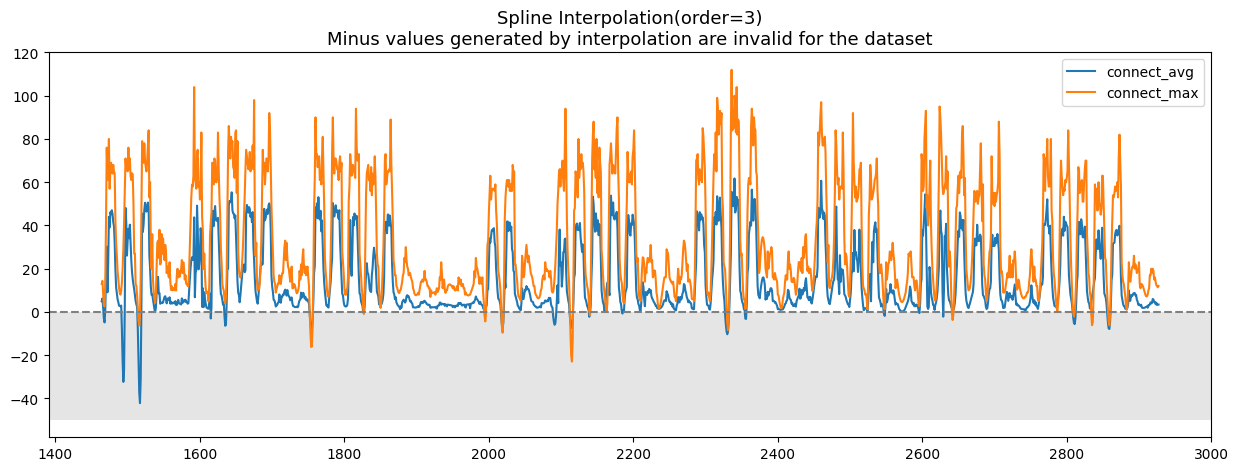

## 3.2 보간/로그차분/파생변수

In [156]:
df_new['connect_avg_rolling'] = np.nan

In [185]:
df_new[target_columns].rolling(24).mean()[30:50] # .rolling(24).mean()

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
%%time
import holidays
from datetime import date

def preprocessing(df):
    # 보간&차분 적용 대상 컬럼 선정
    target_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate',
                      'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

    feature_engineering = ['connect_avg_rolling', 'connect_max_rolling', 'in_handover_rate_rolling', 'out_handover_rate_rolling', 'inter_handover_rate_rolling',
                           'lower_prb_rolling', 'upper_prb_rolling', 'reconfig_rate_rolling', 'lower_bler_rolling', 'upper_bler_rolling',
                           'tot_et_rolling']

    # 추가 파생변수(rolling 통계량)
    df[feature_engineering] = np.nan

    # 기지국 고유 id 리스트
    machine_list = df['machine_id'].unique()

    for idx, machine in enumerate(machine_list):
        # spline3로 결측치 보간 후 bfill로 나머지 결측치 채우기
        tmp = df.loc[df['machine_id'] == machine, target_columns].interpolate(method='spline', order=3).bfill()
        tmp[tmp < 0] = 0 # 음수값으로 보간된 수치에 대해서는 0으로 변환
        df.loc[df['machine_id'] == machine, feature_engineering] = df.loc[df['machine_id'] == machine, target_columns].rolling(window=24).mean() # rolling 평균 적용
        tmp = np.log1p(tmp).diff(periods=24, axis=0) # 로그 차분 24시간 적용, 0값 고려 log1p 적용
        df.loc[df['machine_id'] == machine, target_columns] = tmp # 변경된 값으로

    # df = df.dropna(axis=0, subset=target_columns).reset_index(drop=True) # 로그 차분 결과 발생한 nan 행 제거

    # 시간 파생변수 생성
    df['year'] = df['time'].dt.year # 년
    df['month'] = df['time'].dt.month # 월
    df['day'] = df['time'].dt.day # 일
    df['hour'] = df['time'].dt.hour # 시간
    df['dayofweek'] = df['time'].dt.dayofweek # 요일
    df['is_weekend'] = df['dayofweek'].apply(lambda x : 1 if x >= 5 else 0) # 주중/주말
    df['is_night'] = df['hour'].apply(lambda x : 1 if x >= 23 or x <= 7 else 0) # 주간/야간
    df['is_commute'] = df['hour'].apply(lambda x : 1 if (x >= 7 and x <= 9) or (x >= 17 and x <= 19) else 0)


    # cyclical encoding
    df['day_sin'] = np.sin(df['day'] / 31 * 2 * np.pi)
    df['day_cos'] = np.cos(df['day'] / 31 * 2 * np.pi)

    df['dayofweek_sin'] = np.sin(df['dayofweek'] / 7 * 2 * np.pi)
    df['dayofweek_cos'] = np.cos(df['dayofweek'] / 7 * 2 * np.pi)

    df['hour_sin'] = np.sin(df['hour'] / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['hour'] / 24 * 2 * np.pi)

    # 휴일 컬럼
    kr_holidays = holidays.KR()
    df['is_holiday'] = df['time'].apply(lambda x : 1 if x in kr_holidays else 0)

    # 기지국 파생변수 생성
    df['station'] = df['machine_id'].apply(lambda x : x.split('_')[0])
    return df

df_try = df_new.copy() # 원본 수정 없이 반복적으로 테스트 시행을 위해 df_try에 copy
df_processed = preprocessing(df_try)
df_processed

CPU times: user 1min 7s, sys: 131 ms, total: 1min 7s
Wall time: 1min 8s


,machine_id,time,ckey,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,...,is_night,is_commute,day_sin,day_cos,dayofweek_sin,dayofweek_cos,hour_sin,hour_cos,is_holiday,station
0,MA1074_4,2021-09-01 00:00:00,MA1074_4_20210901_0,20210901.0,0,NaN,NaN,NaN,NaN,NaN,...,1,0,2.012985e-01,0.97953,0.974928,-0.222521,0.000000,1.000000,0,MA1074
1,MA1074_4,2021-09-01 01:00:00,MA1074_4_20210901_1,20210901.0,1,NaN,NaN,NaN,NaN,NaN,...,1,0,2.012985e-01,0.97953,0.974928,-0.222521,0.258819,0.965926,0,MA1074
2,MA1074_4,2021-09-01 02:00:00,MA1074_4_20210901_2,20210901.0,2,NaN,NaN,NaN,NaN,NaN,...,1,0,2.012985e-01,0.97953,0.974928,-0.222521,0.500000,0.866025,0,MA1074
3,MA1074_4,2021-09-01 03:00:00,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,...,1,0,2.012985e-01,0.97953,0.974928,-0.222521,0.707107,0.707107,0,MA1074
4,MA1074_4,2021-09-01 04:00:00,MA1074_4_20210901_4,20210901.0,4,NaN,NaN,NaN,NaN,NaN,...,1,0,2.012985e-01,0.97953,0.974928,-0.222521,0.866025,0.500000,0,MA1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74659,MA2561_18,2021-10-31 19:00:00,MA2561_18_20211031_19,20211031.0,19,-0.126192,-0.147636,-0.001250,0.006266,0.0,...,0,1,-2.449294e-16,1.00000,-0.781831,0.623490,-0.965926,0.258819,0,MA2561
74660,MA2561_18,2021-10-31 20:00:00,MA2561_18_20211031_20,20211031.0,20,-0.093788,0.133531,0.003230,0.000000,0.0,...,0,0,-2.449294e-16,1.00000,-0.781831,0.623490,-0.866025,0.500000,0,MA2561
74661,MA2561_18,2021-10-31 21:00:00,MA2561_18_20211031_21,20211031.0,21,0.408807,0.241162,0.004017,0.000000,0.0,...,0,0,-2.449294e-16,1.00000,-0.781831,0.623490,-0.707107,0.707107,0,MA2561
74662,MA2561_18,2021-10-31 22:00:00,MA2561_18_20211031_22,20211031.0,22,0.177838,0.168623,0.003581,-0.004771,0.0,...,0,0,-2.449294e-16,1.00000,-0.781831,0.623490,-0.500000,0.866025,0,MA2561


In [187]:
# df_processed[['connect_avg', 'connect_max']].plot(kind='line', figsize=(15,5))
# plt.title('Spline Interpolation(order=3)\nMinus values generated by interpolation are invalid for the dataset', fontsize=13)
# plt.axhline(0, linestyle='--', color='grey')
# ax = plt.gca()
# ymin, ymax = ax.get_ylim()
# plt.axhspan(ymin, 0, facecolor='grey', alpha=0.2)
# plt.show()

In [188]:
df.y.value_counts()/df.shape[0],\
df_processed.y.value_counts()/df_processed.shape[0]

(0    0.850439
 1    0.149561
 Name: y, dtype: float64,
 0.0    0.876594
 1.0    0.123406
 Name: y, dtype: float64)

In [189]:
df_processed.isna().sum()

machine_id                         0
time                               0
ckey                           13057
date                           13057
hour                               0
connect_avg                     1224
connect_max                     1224
in_handover_rate                1224
out_handover_rate               1224
inter_handover_rate             1224
lower_prb                       1224
upper_prb                       1224
reconfig_rate                   1224
lower_bler                      1224
upper_bler                      1224
tot_et                          1224
y                                  0
connect_avg_rolling            74664
connect_max_rolling            74664
in_handover_rate_rolling       74664
out_handover_rate_rolling      74664
inter_handover_rate_rolling    74664
lower_prb_rolling              74664
upper_prb_rolling              74664
reconfig_rate_rolling          74664
lower_bler_rolling             74664
upper_bler_rolling             74664
t

## 3.3 분리/스케일링/인코딩

In [139]:
def split_scaling_encoding(df, preprocessing=False, to_automl=False):
    X = df.drop(['ckey', 'date', 'time', 'y'], axis=1)
    y = df['y']

    categorical_columns = ['station', 'machine_id', 'year', 'month']
    numerical_columns = ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb', 'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']


    preprocessor = make_column_transformer(
        (StandardScaler(), numerical_columns),
        (OneHotEncoder(sparse_output=False), categorical_columns),
    )

    if not to_automl: # to_automl이 False인 경우 분리, 스케일링, 인코딩 처리
        # train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        if not preprocessing:
            return X_train, X_test, y_train, y_test
        else:
            X_train_processed = preprocessor.fit_transform(X_train)
            X_test_processed = preprocessor.transform(X_test)
            return X_train_processed, X_test_processed, y_train, y_test, preprocessor

    else: # to_automl이 True인 경우 X, y만 분리 후 return
        return X, y

# X_train_p, X_test_p, y_train, y_test, preprocessor = split_scaling_encoding(df_processed, preprocessing=True, to_automl=False)

X, y = split_scaling_encoding(df_processed, preprocessing=False, to_automl=True)

In [140]:
# pd.DataFrame(X_train_p, columns=preprocessor.get_feature_names_out())

In [141]:
# X_train_p.shape, X_test_p.shape, y_train.shape, y_test.shape

# 4.AutoML

In [142]:
# !pip install -q --pre pycaret
# !pip install -q pycaret[models]

In [143]:
# !pip install -q catboost

## 4.1 환경설정

In [144]:
from pycaret.utils import version
from catboost import CatBoostClassifier
version()

'3.2.0'

In [145]:
from pycaret.classification import *

## 4.2 모델 튜닝

In [146]:
categorical_features = ['station', 'machine_id', 'year', 'month']

numerical_features = ['connect_avg', 'connect_max', 'in_handover_rate',
                    'out_handover_rate', 'inter_handover_rate', 'lower_prb', 'upper_prb',
                    'reconfig_rate', 'lower_bler', 'upper_bler', 'tot_et']

passthrough = ['is_weekend', 'is_night', 'is_commute', 'is_holiday', 'day_sin',
               'day_cos', 'dayofweek_sin', 'dayofweek_cos', 'hour_sin', 'hour_cos']

ignore_features = ['day', 'dayofweek', 'hour']

In [147]:
smote_s = setup(data=X, target=y,
          session_id=124,
          train_size=0.8, fold=5, verbose=True,
          ordinal_features=None,
          categorical_features=categorical_features,
          numeric_features=numerical_features,
          keep_features = passthrough,
          normalize=True,
          normalize_method='zscore',
          fold_strategy='stratifiedkfold',
          fold_shuffle=True,
          fix_imbalance=True)

ValueError: ignored

In [ ]:
# custom metric 정의
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# custom metric 추가
add_metric('f2', 'F2', f2_score, target='pred')

In [ ]:
def f0_5_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5)

add_metric('f0_5', 'F0.5', f0_5_score, target='pred')

In [148]:
get_metrics()

AttributeError: ignored

In [87]:
%%time
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F2,F0.5
Fold,,,,,,,,,
0,0.8969,0.9147,0.5277,0.5906,0.5573,0.4992,0.5002,0.5391,0.5768
1,0.8992,0.9218,0.5719,0.5937,0.5826,0.5253,0.5254,0.5761,0.5892
2,0.9015,0.9167,0.5439,0.6121,0.5760,0.5206,0.5217,0.5563,0.5972
3,0.9016,0.9170,0.5467,0.6119,0.5775,0.5220,0.5231,0.5586,0.5977
4,0.9021,0.9204,0.5546,0.6131,0.5824,0.5272,0.5280,0.5654,0.6005
Mean,0.9003,0.9181,0.5490,0.6043,0.5752,0.5188,0.5197,0.5591,0.5923
Std,0.0020,0.0026,0.0144,0.0100,0.0093,0.0101,0.0100,0.0121,0.0086


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 13.7 s, sys: 317 ms, total: 14.1 s
Wall time: 1min 6s


In [88]:
# params = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'num_leaves': [31, 63, 127],
#     'n_estimators': [100, 200, 500]
# }

In [89]:
# params = {"max_depth": [5,10,15,20,25],
#           "max_features": np.random.randint(1, len(boston.columns),20),
#           "min_samples_leaf": [2,3,4,5,6]}

In [90]:
%%time
# tuned_lgbm = tune_model(lgbm, custom_grid= None, optimize = 'F1', fold=3, n_iter=10)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [91]:
# default model
print(lgbm)

# tuned model
# print(tuned_lgbm)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=124, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


# threshold 변경

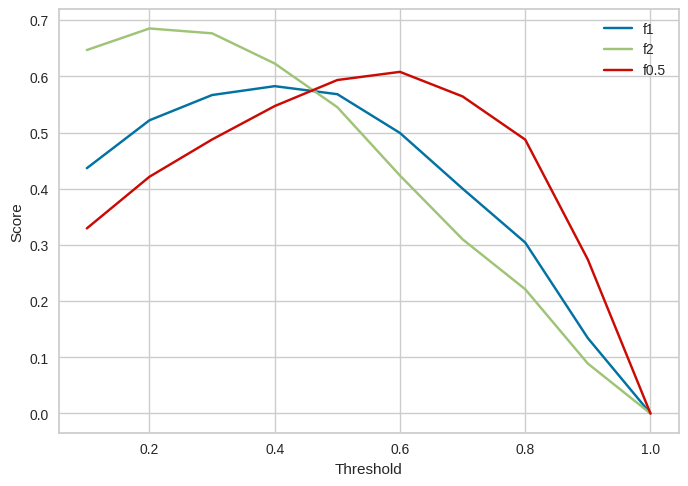

In [124]:
# threshold 리스트
thresholds = np.linspace(0.1, 1, 10)

# score 저장 리스트
f1_scores = []
f2_scores = []
f0_5_scores = []
accuracy_scores = []

for threshold in thresholds:
    X = smote_s.X_test_transformed
    y = smote_s.y_test
    predictions = lgbm.predict_proba(X)[:, 1]
    predictions = np.where(predictions > threshold, 1, 0)
    f1_scores.append(fbeta_score(y, predictions, beta=1))
    f2_scores.append(fbeta_score(y, predictions, beta=2))
    f0_5_scores.append(fbeta_score(y, predictions, beta=0.5))
    accuracy_scores.append(accuracy_score(y, predictions))

# 그래프 그리기
plt.plot(thresholds, f1_scores, label = 'f1')
plt.plot(thresholds, f2_scores, label = 'f2')
plt.plot(thresholds, f0_5_scores, label = 'f0.5')
# plt.plot(thresholds, accuracy_scores, label = 'accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

73187    0.0
9898     0.0
58298    0.0
10851    0.0
44919    1.0
        ... 
62895    1.0
8080     0.0
22479    0.0
14713    0.0
43204    0.0
Name: y, Length: 58752, dtype: float32

# 5.zscore

In [92]:
from scipy.stats import zscore

In [93]:
zscore_df = df_processed[target_columns]

In [94]:
zscore_df

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et
0,-0.016140,0.058841,-0.003187,0.000000,0.000000,-0.128298,-0.927531,0.019080,0.055756,-0.022035,0.212200
1,-0.040375,-0.039221,-0.381298,0.004795,0.006286,0.081664,-0.919199,0.015582,0.187271,0.518314,-0.047953
2,0.060340,-0.163080,-0.067532,0.005599,-0.001361,0.266548,-0.440348,0.007307,0.115528,0.425684,-0.287069
3,0.226949,-0.007034,0.003485,-0.000007,0.001350,0.012500,-0.453520,-0.016292,0.013146,-0.382483,0.114266
4,0.175298,0.090093,-0.077281,-0.000262,-0.001361,-0.366746,-1.223239,-0.002125,0.030046,-0.720330,0.138850
...,...,...,...,...,...,...,...,...,...,...,...
73435,-0.126192,-0.147636,-0.001250,0.006266,0.000000,0.183253,0.281329,-0.000098,-0.114350,-0.020999,-0.108241
73436,-0.093788,0.133531,0.003230,0.000000,0.000000,-0.021939,0.275821,-0.000393,-0.126718,0.051505,-0.015961
73437,0.408807,0.241162,0.004017,0.000000,0.000000,0.004103,0.385658,0.001281,-0.235796,0.113865,0.149389
73438,0.177838,0.168623,0.003581,-0.004771,0.000000,0.018482,-0.257566,-0.004550,-0.191984,-0.076920,0.143955


In [95]:
zscore(zscore_df)

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et
0,-0.028265,0.110807,-0.023510,-0.001064,0.000009,-0.198337,-1.437082,0.331682,0.109418,-0.039351,0.110212
1,-0.075946,-0.066502,-1.325574,0.423962,0.040307,0.133345,-1.424136,0.268705,0.369599,0.894121,-0.016385
2,0.122205,-0.290457,-0.245087,0.495292,-0.008712,0.425410,-0.680095,0.119757,0.227668,0.734099,-0.132746
3,0.449997,-0.008304,-0.000533,-0.001685,0.008663,0.024085,-0.700561,-0.305048,0.025122,-0.662039,0.062555
4,0.348377,0.167316,-0.278660,-0.024321,-0.008717,-0.575019,-1.896555,-0.050029,0.058556,-1.245682,0.074518
...,...,...,...,...,...,...,...,...,...,...,...
73435,-0.244785,-0.262533,-0.016839,0.554422,0.000009,0.293827,0.441250,-0.013535,-0.227109,-0.037561,-0.045723
73436,-0.181033,0.245859,-0.001410,-0.001064,0.000009,-0.030320,0.432692,-0.018856,-0.251577,0.087691,-0.000817
73437,0.807791,0.440471,0.001298,-0.001064,0.000009,0.010819,0.603358,0.011278,-0.467370,0.195421,0.079647
73438,0.353374,0.309309,-0.000203,-0.424043,0.000009,0.033535,-0.396088,-0.093679,-0.380695,-0.134168,0.077002


In [96]:
def ucl(series, z=2):
    ucl = series.mean() + series.std() * z
    return np.where(series > ucl, 1, 0)

def lcl(series, z=2):
    lcl = series.mean() - series.std() * z
    return np.where(series < lcl, 1, 0)

def side(series, z=2):
    ucl = series.mean() + series.std() * z
    lcl = series.mean() - series.std() * z
    return np.where((series > ucl) | (series < lcl), 1, 0)

def outlier_zscore(df, col):
    if col in ['lower_prb', 'upper_prb', 'lower_bler', 'upper_bler']:
        return ucl(df[col]), 'ucl'
    elif col in ['connect_avg', 'connect_max', 'in_handover_rate', 'out_handover_rate', 'inter_handover_rate', 'tot_et']:
        return lcl(df[col]), 'lcl'
    else:
        return side(df[col]), 'side'

In [97]:
np.unique(ucl(zscore_df['connect_avg']), return_counts=True)

(array([0, 1]), array([71443,  1997]))

In [98]:
tmp = zscore_df.copy()
anomalies_df = pd.DataFrame()
for col in tmp.columns:
    res, typ = outlier_zscore(tmp, col)
    anomalies_df[f'{col}_z'] = res
    print(f'{col}의 이상치 비율은 {np.round(np.mean(res)*100, 2)}%({typ})')

connect_avg의 이상치 비율은 2.58%(lcl)
connect_max의 이상치 비율은 2.22%(lcl)
in_handover_rate의 이상치 비율은 0.93%(lcl)
out_handover_rate의 이상치 비율은 0.81%(lcl)
inter_handover_rate의 이상치 비율은 0.24%(lcl)
lower_prb의 이상치 비율은 2.86%(ucl)
upper_prb의 이상치 비율은 3.07%(ucl)
reconfig_rate의 이상치 비율은 0.92%(side)
lower_bler의 이상치 비율은 1.94%(ucl)
upper_bler의 이상치 비율은 1.99%(ucl)
tot_et의 이상치 비율은 2.7%(lcl)


In [99]:
for (idx, col) in enumerate(target_columns):
    print(idx, col)

0 connect_avg
1 connect_max
2 in_handover_rate
3 out_handover_rate
4 inter_handover_rate
5 lower_prb
6 upper_prb
7 reconfig_rate
8 lower_bler
9 upper_bler
10 tot_et


In [100]:
df_org[target_columns + ['y']].groupby('y').mean()

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate,lower_bler,upper_bler,tot_et
y,,,,,,,,,,,
0,21.090100,37.414727,96.653688,99.764482,99.781487,27.772763,25.775308,101.074137,12.013264,21.934688,39474.127589
1,19.283993,36.958388,92.617417,99.562896,99.523938,30.505702,32.385277,101.713289,19.712757,36.692422,35934.344164


In [101]:
anomalies_df

,connect_avg_z,connect_max_z,in_handover_rate_z,out_handover_rate_z,inter_handover_rate_z,lower_prb_z,upper_prb_z,reconfig_rate_z,lower_bler_z,upper_bler_z,tot_et_z
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
73435,0,0,0,0,0,0,0,0,0,0,0
73436,0,0,0,0,0,0,0,0,0,0,0
73437,0,0,0,0,0,0,0,0,0,0,0
73438,0,0,0,0,0,0,0,0,0,0,0


In [102]:
anomalies_df['total'] = anomalies_df.mean(axis=1)

In [103]:
anomalies_df['total'].sort_values(ascending=False)

66080    0.545455
65201    0.545455
65419    0.454545
20786    0.454545
20784    0.454545
           ...   
26308    0.000000
26309    0.000000
26310    0.000000
26311    0.000000
73439    0.000000
Name: total, Length: 73440, dtype: float64

In [104]:
anomalies_df['total'].value_counts()

0.000000    63893
0.090909     5838
0.181818     2535
0.272727      835
0.363636      241
0.454545       96
0.545455        2
Name: total, dtype: int64

In [105]:
anomalies_df[anomalies_df['total'] != 0]

,connect_avg_z,connect_max_z,in_handover_rate_z,out_handover_rate_z,inter_handover_rate_z,lower_prb_z,upper_prb_z,reconfig_rate_z,lower_bler_z,upper_bler_z,tot_et_z,total
102,0,0,0,0,0,0,0,1,0,0,0,0.090909
122,0,0,0,0,0,0,1,0,0,0,0,0.090909
148,0,0,0,0,0,0,1,0,0,0,0,0.090909
272,0,0,0,0,0,0,1,0,0,0,0,0.090909
315,0,0,0,0,0,1,1,0,0,0,0,0.181818
...,...,...,...,...,...,...,...,...,...,...,...,...
73383,0,0,0,0,0,0,0,0,0,1,0,0.090909
73418,0,0,0,0,0,0,1,0,0,0,0,0.090909
73419,0,0,1,0,0,0,0,0,0,0,0,0.090909
73429,0,0,1,0,0,0,0,0,1,0,0,0.181818


In [106]:
9547 / df_processed.shape[0]

0.12999727668845315

# 6.Isolation Forest

In [107]:
from sklearn.ensemble import IsolationForest

In [108]:
true_label = df_processed['y']

In [109]:
clf = IsolationForest(random_state=0)
clf.fit(zscore_df)

IsolationForest(bootstrap=False, contamination='auto', max_features=1.0,
                max_samples='auto', n_estimators=100, n_jobs=None,
                random_state=0, verbose=0, warm_start=False)

In [110]:
anomaly_score = -np.sort(clf.score_samples(zscore_df))

In [111]:
anomaly_score

array([0.73536607, 0.73387497, 0.73337861, ..., 0.30726064, 0.30722949,
       0.30720237])

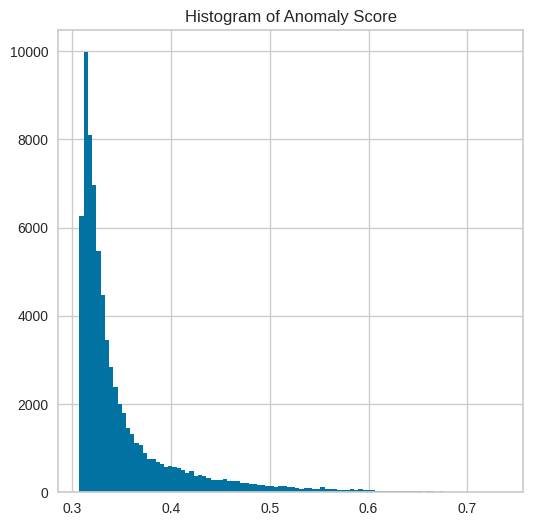

In [112]:
plt.figure(figsize=(6,6))
plt.hist(anomaly_score, bins=100)
plt.title("Histogram of Anomaly Score")
# sns.kdeplot(anomaly_score)
plt.show()

In [113]:
i_forest_anomalies = np.where(clf.predict(zscore_df)==1, 0, 1)

In [114]:
i_forest_anomalies

array([0, 0, 0, ..., 0, 0, 0])

In [115]:
print('Isolation Accuracy score :', accuracy_score(true_label, i_forest_anomalies).round(4))
print('Isolation F1 score :', f1_score(true_label, i_forest_anomalies).round(4))

Isolation Accuracy score : 0.8479
Isolation F1 score : 0.0447


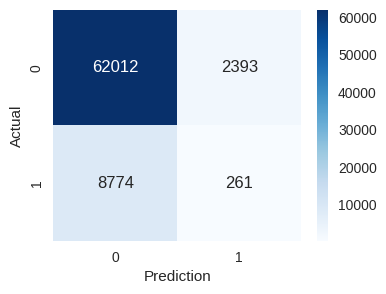

In [116]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(true_label, i_forest_anomalies), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

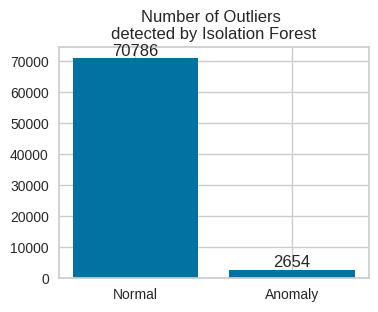

In [134]:
fig, axs = plt.subplots(1,1,figsize=(4,3))

label, count = np.unique(i_forest_anomalies, return_counts=True)

plt.title('Number of Outliers \ndetected by Isolation Forest')
bar_container = plt.bar(label, count)
plt.bar_label(bar_container)
plt.xticks(ticks=label, labels=['Normal', 'Anomaly'])
plt.show()